In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# This connects your google drive to the google.colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_file_path = '/content/drive/MyDrive/archive.zip'
# This is the path to the archive.zip(the dataset)

In [ ]:
import zipfile
import os

# Correct path to the ZIP file
zip_file_path = '/content/drive/MyDrive/archive.zip'

# Specify the folder to extract the contents
extract_folder = '/content/Crop Prediction'

# Create the folder if it doesn't exist
os.makedirs(extract_folder, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Extraction complete!")

Extraction complete!


In [ ]:
# Models used for this project
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
# Image size = 256 by 256
IMAGE_SIZE=256
BATCH_SIZE=32
EPOCHS=50
CHANNELS=3

In [ ]:
# This aids in accessing the images in the directory
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    '/content/Crop Prediction/crop_prediction',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE,

)



In [ ]:
# This gives the names of the classes
class_names= dataset.class_names
class_names

['corn', 'rice', 'wheat']

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)     # 32 is batch size , 256x256 is image size and 3 is RGB color
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 0 0 0 0 0 1 1 1 2 0 1 0 0 0 1 2 1 1 2 2 2 1 0 2 0 1 1 1 2]


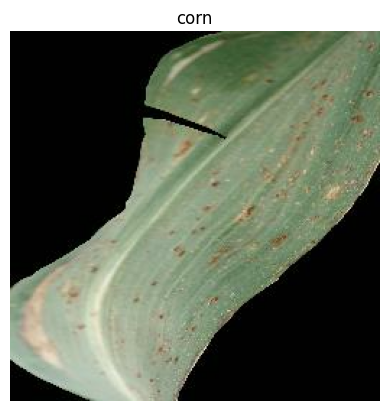

In [ ]:
# This prints the shape of the image badges with its corresponding labels
for image_batch, label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype('uint8'))
  plt.title(class_names[label_batch[0]])
  plt.axis('off')

In [ ]:
# This extracts one badge of images and their labels from our dataset
plt.figure(figsize=(12,12))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax= plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

NameError: name 'plt' is not defined

In [ ]:
# This gives the number of badges that would be used for training
train_size = 0.8
len(dataset)*train_size

67.2

In [ ]:
# This function splits the dataset into proportions(training, validation, testing) with corresponding allocations(0.8, 0.1, 0.1)
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [ ]:
#This partitions the ds into training, validation and testing
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
# This optimizes the performances of our dataset(Memory efficiency, Randomized order & fast data loading)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# This code resizes input image, rescales pixel values for suitable model training
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [ ]:
# This enables the model to see different versions of the same image which encourages robustness
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
# This increases the size of the images using data augmentation enabling robustness
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#This code defines a CNN model using the Keras Sequential API

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)





In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# This compiles the model with the following settings
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.5480 - loss: 0.8677 - val_accuracy: 0.8633 - val_loss: 0.3959
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.9138 - loss: 0.2456 - val_accuracy: 0.9102 - val_loss: 0.3242
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.9607 - loss: 0.1448 - val_accuracy: 0.9492 - val_loss: 0.1416
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.9555 - loss: 0.1217 - val_accuracy: 0.9062 - val_loss: 0.2752
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.9566 - loss: 0.1407 - val_accuracy: 0.9727 - val_loss: 0.0915
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.9680 - loss: 0.0863 - val_accuracy: 0.9531 - val_loss: 0.1379
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.9710 - loss: 0.0931 - val_accuracy: 0.9727 - val_loss: 0.0873
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.8998 - loss: 0.2871 - val_accuracy: 0.9766 - v

In [ ]:
scores = model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 927ms/step - accuracy: 0.9766 - loss: 0.0874


In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']

Text(0.5, 1.0, 'training and validation loss')

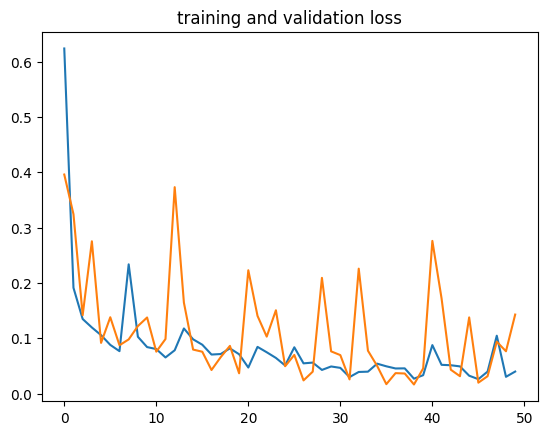

In [ ]:
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='validation loss')
# plt.legend(loc=' top right')
plt.title('training and validation loss')